In [1]:
import requests
from requests.exceptions import RequestException
from bs4 import BeautifulSoup
import csv
import pandas as pd

def fetch_html_content(url: str) -> str:
    """
    Fetches the HTML content from the given URL.

    Args:
        url (str): The URL to fetch the HTML content from.

    Returns:
        str: The HTML content of the page.

    Raises:
        RequestException: If the request fails.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for 4xx or 5xx status codes
        return response.text
    except RequestException as e:
        print(f"Failed to retrieve the webpage: {e}")
        return ""

In [2]:
def fetch_page(page_number):
    url = f'https://www.rottentomatoes.com/browse/movies_at_home/?page={page_number}'
    response = requests.get(url)
    return response.text if response.status_code == 200 else None

In [3]:
def parse_movies(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    tiles = soup.find_all('div', class_='js-tile-link')
    movie_data = []
    for tile in tiles:
        title_tag = tile.find('span', {'data-qa': 'discovery-media-list-item-title'})
        date_tag = tile.find('span', {'data-qa': 'discovery-media-list-item-start-date'})
        score_tags = tile.find('score-pairs-deprecated')
        if title_tag and date_tag and score_tags:
            title = title_tag.get_text(strip=True)
            streaming_date = date_tag.get_text(strip=True)
            critic_score = score_tags.get('criticsscore')
            audience_score = score_tags.get('audiencescore')
            url_tag = tile.find('a', {'data-qa': 'discovery-media-list-item-caption'})
            url = 'https://www.rottentomatoes.com' + url_tag['href'] if url_tag and 'href' in url_tag.attrs else 'No URL'
            movie_data.append([title, url, critic_score, audience_score, streaming_date])
    return movie_data

In [4]:
def save_movies_to_csv(movies):
    with open('movies.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Title', 'URL', 'Critic Score', 'Audience Score', 'Streaming Date'])
        for movie in movies:
            writer.writerow(movie)

In [7]:
def main():
    all_movies = []
    page = 1
    while len(all_movies) < 5500:
        html_content = fetch_page(page)
        if not html_content:
            print("No more pages or network error.")
            break
        movies = parse_movies(html_content)
        all_movies.extend(movies)
        print(f"Retrieved {len(movies)} movies from page {page}. Total: {len(all_movies)}")
        page += 1
        if not movies:
            print("No more movies found, stopping.")
            break

    save_movies_to_csv(all_movies)
    print("Movies saved to CSV.")

if __name__ == "__main__":
    main()

# Reading the CSV file using pandas
df = pd.read_csv("movies.csv")
print(df)

Retrieved 16 movies from page 1. Total: 16
Retrieved 36 movies from page 2. Total: 52
Retrieved 62 movies from page 3. Total: 114
Retrieved 88 movies from page 4. Total: 202
Retrieved 110 movies from page 5. Total: 312
Retrieved 110 movies from page 6. Total: 422
Retrieved 110 movies from page 7. Total: 532
Retrieved 110 movies from page 8. Total: 642
Retrieved 110 movies from page 9. Total: 752
Retrieved 110 movies from page 10. Total: 862
Retrieved 110 movies from page 11. Total: 972
Retrieved 110 movies from page 12. Total: 1082
Retrieved 110 movies from page 13. Total: 1192
Retrieved 110 movies from page 14. Total: 1302
Retrieved 110 movies from page 15. Total: 1412
Retrieved 110 movies from page 16. Total: 1522
Retrieved 110 movies from page 17. Total: 1632
Retrieved 110 movies from page 18. Total: 1742
Retrieved 110 movies from page 19. Total: 1852
Retrieved 110 movies from page 20. Total: 1962
Retrieved 110 movies from page 21. Total: 2072
Retrieved 110 movies from page 22. Tota

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
data = pd.read_csv('/content/movies.csv')

In [11]:
print(data['Audience Score'].isnull().sum())
data = data.dropna(subset=['Audience Score']) #'Audience Score' is the column with audience scores
data['audience_score_binary'] = (data['Audience Score'] >= 50).astype(int)
data.drop(columns=['Audience Score'], inplace=True)

579


<ipython-input-11-cd2bcd08aebf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['audience_score_binary'] = (data['Audience Score'] >= 50).astype(int)
<ipython-input-11-cd2bcd08aebf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Audience Score'], inplace=True)


In [12]:
le = LabelEncoder()
for column in data.columns[data.dtypes == 'object']:
    data[column] = le.fit_transform(data[column])

In [13]:
X = data.drop('audience_score_binary', axis=1)
y = data['audience_score_binary']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [16]:
model = LogisticRegression()

In [17]:
pipeline = Pipeline([
    ('logistic_regression', model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8899521531100478


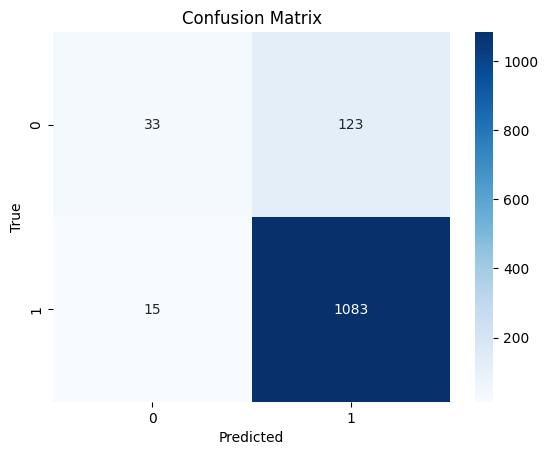

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8980099502487562
Recall: 0.9863387978142076
F1 Score: 0.9401041666666667
